In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In this notebook, we evaluate the Concrete KNN for different rounding values ().


The logs are saved in history.txt file, where we store: 

```
type: type of dataset if it's a make_moon, make_circle or make_classification dataset.
n: number of examples
dims: number of features
qbit: quantized bit
rounding: from -1 to 7
    Rounding = -1: means there is no rounding
    Rounding >= 7: Very costy, execution fails because it requires a lot of memory
cbit: max bitwidth of the circuit
compile_time: compilation
key_time: generation key 
sk_score: score of scikit learn
simul_score: score in simulation mode
fhe_time: execution time for 1 sample
```

From the graph below:

For circuits < 8 bits, rounding improves:
- the keygen and FHE execution timing
- decrease in the loss

For circuits = 8

Without rounding:
- keygen takes a significant time
- best compromise for rounding: 5 or 6

For circuits > 9

- Without rounding, we have a OOM 
- Rounding to 5 can be the best compromise 

In [10]:
df = pd.read_csv("history.txt")
df

,type,n,dims,qbit,rounding,cbit,compile_time,key_time,sk_score,simul_score,fhe_time
0,moon,5,2,3,3,7,1.211964,79.463324,0.600000,0.600000,2.955894
1,moon,5,2,3,4,7,1.761482,83.945122,0.600000,0.600000,2.258097
2,moon,5,2,3,5,7,2.919005,103.351317,0.600000,0.600000,3.176338
3,moon,5,2,3,6,7,2.724613,102.536228,0.600000,0.600000,3.071910
4,moon,5,2,3,7,7,2.918757,102.195243,0.600000,0.600000,2.355688
...,...,...,...,...,...,...,...,...,...,...,...
83,circle,22,2,3,6,7,258.910233,348.164014,0.956522,0.956522,27.623939
84,circle,22,2,3,7,7,261.481122,337.288746,0.956522,0.956522,29.031935
85,classif,25,20,3,4,8,139.667937,367.062176,0.840000,0.800000,14.368091
86,classif,25,20,3,5,8,74.082824,423.295262,0.840000,0.840000,17.770030


In [11]:
grouped_columns = ['type', 'n', 'dims', 'qbit', 'cbit', 'rounding']
non_grouped_columns = list(set(df.columns) - set(grouped_columns))

grouped_df = df.groupby(grouped_columns).agg(['mean', 'median'])

# Calculate the boolean mask for the condition
mask = grouped_df[('compile_time', 'median')] != grouped_df[('compile_time', 'mean')]

for col in non_grouped_columns:
    mask |= grouped_df[(col, 'median')] != grouped_df[(col, 'mean')]

highlighted_rows = grouped_df[mask]
highlighted_rows

compile_time                 key_time  \
                                           mean      median         mean   
type    n  dims qbit cbit rounding                                         
classif 20 15   3    8     7         124.870325  124.870325  1860.783509   
        25 20   3    8    -1          65.288982   65.288982          NaN   
                     9    -1          62.297814   62.074851          NaN   
moon    5  2    3    7     3           1.903035    1.317727    79.757981   
                           4           1.738013    1.761482    83.757061   
                           5           3.614993    2.919005   102.793600   

                                                 sk_score        simul_score  \
                                         median      mean median        mean   
type    n  dims qbit cbit rounding                                             
classif 20 15   3    8     7        1860.783509  0.700000    0.7         0.7   
        25 20   3    8    -1                NaN       NaN    NaN         NaN   
                     9    -1                inf       NaN    NaN         NaN   
moon    5  2    3    7     3          79.463324  0.466667    0.6         0.4   
                           4          83.945122  0.466667    0.6         0.4   
                           5         103.260538  0.466667    0.6         0.4   

                                           fhe_time            
                                   median      mean    median  
type    n  dims qbit cbit rounding                             
classif 20 15   3    8     7          0.7       NaN       inf  
        25 20   3    8    -1          NaN       NaN       NaN  
                     9    -1          NaN       NaN       NaN  
moon    5  2    3    7     3          0.4  2.683121  2.694774  
                           4          0.4  2.306249  2.316854  
                           5          0.4  2.849629  2.917155

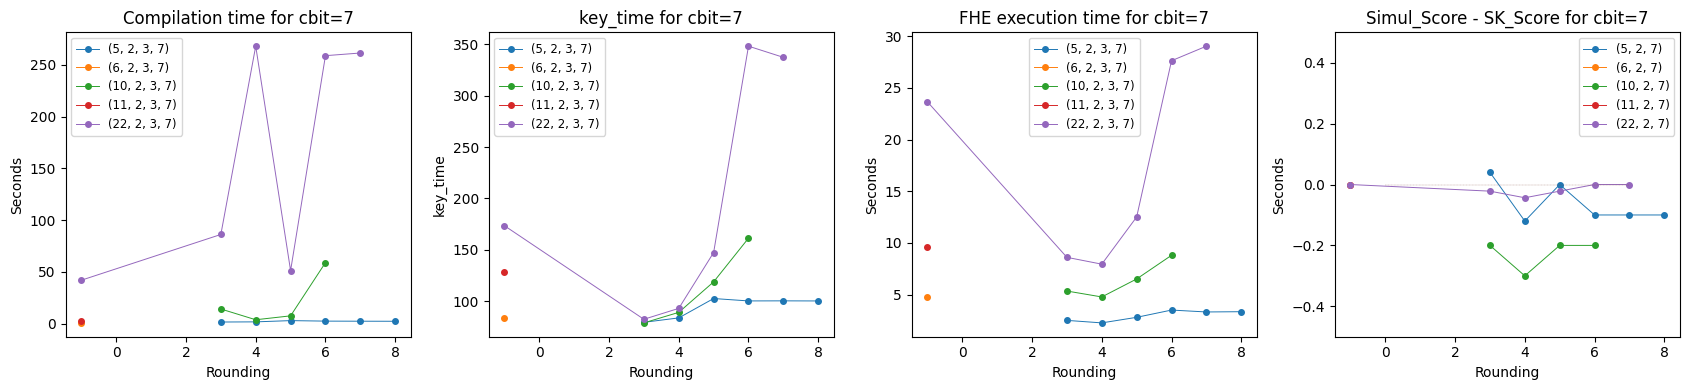

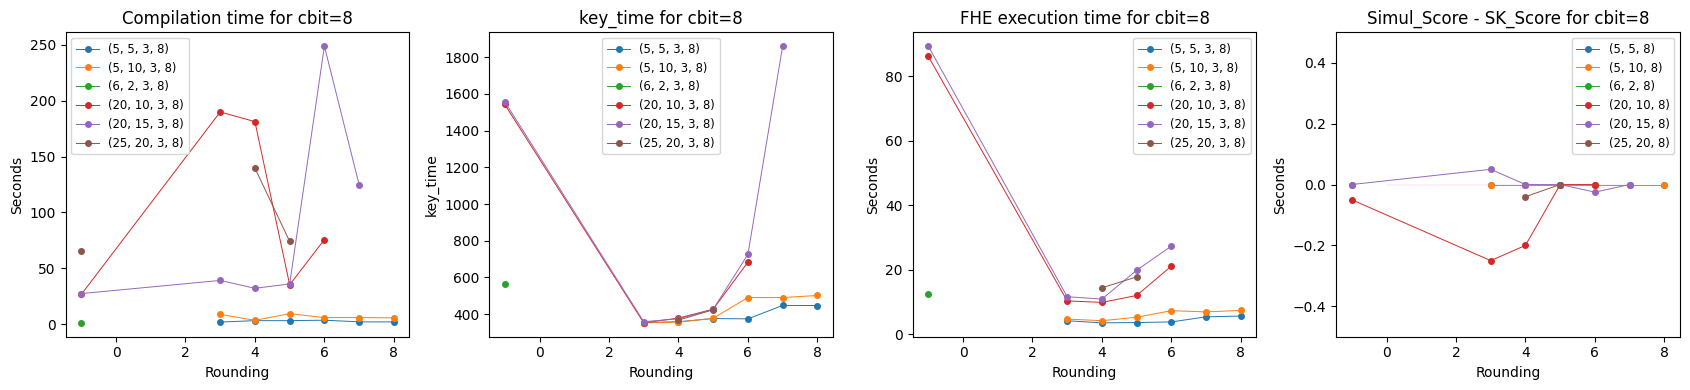

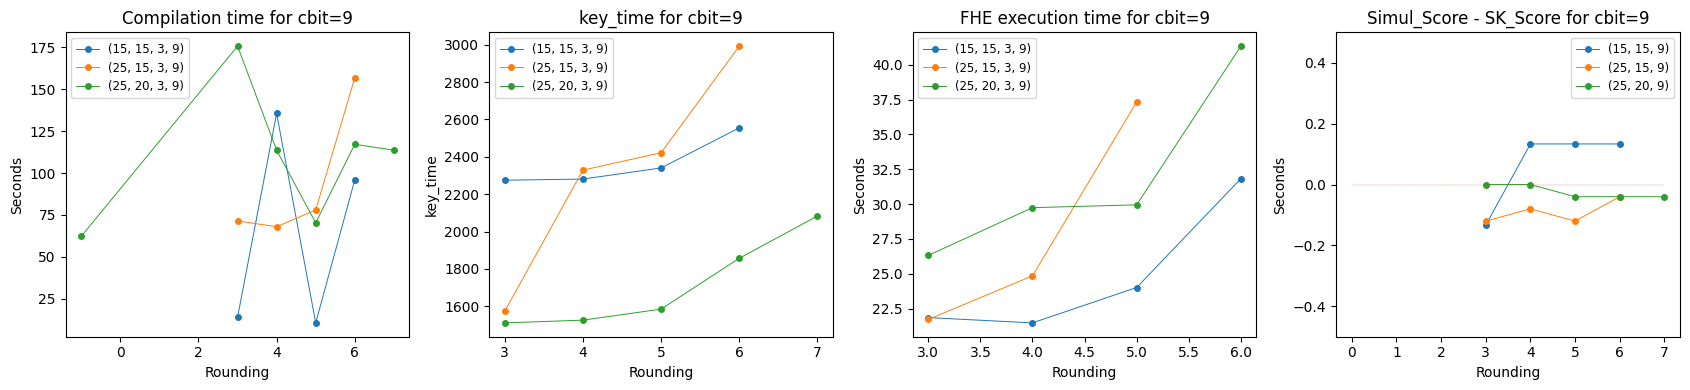

In [12]:
for unique_cbit in df['cbit'].unique():
    # Create the pivot table for compile_time
    compile_pivot_table = pd.pivot_table(df[df['cbit'] == unique_cbit].reset_index(),
                                 index='rounding', columns=['n', 'dims', 'qbit', 'cbit'],
                                 values='compile_time')

    # Create the pivot table for compile_key
    key_gen_pivot_table = pd.pivot_table(df[df['cbit'] == unique_cbit].reset_index(),
                                     index='rounding', columns=['n', 'dims', 'qbit', 'cbit'],
                                     values='key_time')

    # Create the pivot table for compile_key
    fhe_pivot_table = pd.pivot_table(df[df['cbit'] == unique_cbit].reset_index(),
                                     index='rounding', columns=['n', 'dims', 'qbit', 'cbit'],
                                     values='fhe_time')

    score_pivot_table = pd.pivot_table(df[df['cbit'] == unique_cbit].reset_index(),
                                     index='rounding', columns=['n', 'dims',  'cbit'],
                                     values=['simul_score', 'sk_score'])
    fig, axes = plt.subplots(1, 4, figsize=(17, 4))

    # Plot the compilation time
    plot1 = compile_pivot_table.plot(ax=axes[0], legend=True,  marker='o', linewidth=0.7, markersize=4)
    axes[0].set_ylabel('Seconds')
    axes[0].set_xlabel('Rounding')
    axes[0].set_title(f'Compilation time for cbit={unique_cbit}')
    plot1.legend(fontsize='small') 


    # Plot the genkey time
    plot3 = key_gen_pivot_table.plot(ax=axes[1], legend=True,  marker='o', linewidth=0.7, markersize=4)
    axes[1].set_ylabel('key_time')
    axes[1].set_xlabel('Rounding')
    axes[1].set_title(f'key_time for cbit={unique_cbit}')
    plot3.legend(fontsize='small') 


    # Plot the FHE execution time for 1 sample
    plot2 = fhe_pivot_table.plot(ax=axes[2], legend=True,  marker='o', linewidth=0.7, markersize=4)
    axes[2].set_ylabel('Seconds')
    axes[2].set_xlabel('Rounding')
    axes[2].set_title(f'FHE execution time for cbit={unique_cbit}')
    plot2.legend(fontsize='small') 

    # simulation score vs scikit learn score
    # I plot the simule_score - sk_score, for a better visualization
    # If the curve is above 0 -> Concrete KNN behaves better than SK KNN 
    plot3 = (score_pivot_table['simul_score'] - score_pivot_table['sk_score'] ).plot(ax=axes[3], legend=True,  marker='o', linewidth=0.7, markersize=4)
    axes[3].plot(range(8), [0] * 8, '--', linewidth=.2)
    axes[3].set_ylabel('Seconds')
    axes[3].set_xlabel('Rounding')
    axes[3].set_ylim(-.5, .5)
    axes[3].set_title(f'Simul_Score - SK_Score for cbit={unique_cbit}')
    plot3.legend(fontsize='small') 

    plt.tight_layout()
    plt.show()